In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')
import statsmodels.api as sm
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from itertools import cycle
import matplotlib.pyplot as pl

### Binary classification

In [2]:
mat = pd.read_csv("student/student-mat.csv", sep=';')
por = pd.read_csv("student/student-por.csv", sep=';')

In [3]:
mat['subject'] = 'Math'
por['subject'] = 'Portuguese'

In [4]:
df = pd.concat([mat,por])

In [5]:
df.columns = ['school','sex','age','address','family_size','parents_status','mother_education','father_education',
           'mother_job','father_job','reason','guardian','commute_time','study_time','failures','school_support',
          'family_support','paid_classes','activities','nursery','desire_higher_edu','internet','romantic','family_quality',
          'free_time','go_out','weekday_alcohol_usage','weekend_alcohol_usage','health','absences','period1_score','period2_score','final_score', 'subject']

In [6]:
df['final_grade'] = 'na'
df.loc[(df.final_score >= 10) & (df.final_score <= 20), 'final_grade'] = 'pass' 
df.loc[(df.final_score >= 0) & (df.final_score <= 10), 'final_grade'] = 'fail' 
df.head(5)

,school,sex,age,address,family_size,parents_status,mother_education,father_education,mother_job,father_job,...,go_out,weekday_alcohol_usage,weekend_alcohol_usage,health,absences,period1_score,period2_score,final_score,subject,final_grade
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,1,1,3,6,5,6,6,Math,fail
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,3,1,1,3,4,5,5,6,Math,fail
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,2,2,3,3,10,7,8,10,Math,fail
3,GP,F,15,U,GT3,T,4,2,health,services,...,2,1,1,5,2,15,14,15,Math,pass
4,GP,F,16,U,GT3,T,3,3,other,other,...,2,1,2,5,4,6,10,10,Math,fail


In [7]:
dfd = df.copy()
dfd = dfd.drop([ 'final_score', 'period2_score', 'period1_score', 'failures'], axis=1)

In [8]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(dfd,test_size=0.3)

In [9]:
def preprocessing_data(data):
    bin_dict = {'no': 0, 'yes': 1}
    data['final_grade'] = data['final_grade'].map({'fail': 0, 'pass': 1})
    data['sex'] = data['sex'].map({'F': 0, 'M': 1})
    bin_features = ['school_support', 'family_support', 'paid_classes', 'activities', 'nursery', 'desire_higher_edu', 'internet', 'romantic']
    for feature in bin_features:
        data[feature] = data[feature].map(bin_dict)
    dummies_features = ['school', 'address', 'family_size', 'parents_status', 'mother_job', 'father_job', 'reason', 'guardian', 'subject']
    for feature in dummies_features:
        data = pd.concat((data, pd.get_dummies(data[feature], prefix=feature + '_')),1)
        data = data.drop([feature], axis=1)
    return (data)

In [10]:
train = preprocessing_data(train)
test = preprocessing_data(test)
train = train[test.columns]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

In [11]:
X_train = train.drop('final_grade',axis=1)
y_train = train.final_grade

X_test = test.drop('final_grade',axis=1)
y_test = test.final_grade

In [28]:
ros = RandomOverSampler(random_state=0)
X_train, y_train = ros.fit_resample(X_train, y_train)

In [13]:
def train_predict_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    print("Accuracy: {:.3f}".format(accuracy_score(y_test, pred)))
    
    cm = confusion_matrix(y_test, pred)
    print(cm)
   
    print(classification_report(y_test, pred))
    
    preds = model.predict_proba(X_test)
    preds = preds[:,1]
    fpr, tpr, _ = metrics.roc_curve(y_test, preds)
    print('Auc score: ' + str(metrics.auc(fpr, tpr)))
    
    pl.plot(fpr, tpr)
    pl.xlim([-0.1, 1.1])
    pl.ylim([-0.1, 1.1])
    pl.xlabel('FPR')
    pl.ylabel('TPR')
    pl.title('ROC curve (AUC={:.3f})'.format(metrics.auc(fpr, tpr)))
    pl.show()

### Catboost

In [18]:
from catboost import Pool, CatBoostClassifier
categorical_features_indices = np.where(X_train.dtypes != np.float)[0]
print(categorical_features_indices)
train_dataset = Pool(data=X_train,
                     label=y_train,
                     cat_features=categorical_features_indices)
test_dataset = Pool(data=X_test,
                     label=y_test,
                     cat_features=categorical_features_indices)
model = CatBoostClassifier(iterations=10,
                           learning_rate=1,
                           depth=2,
                           loss_function='MultiClass')
# Fit model
model.fit(train_dataset)
# Get predicted classes
preds_class = model.predict(test_dataset)
# Get predicted probabilities for each class
preds_proba = model.predict_proba(test_dataset)
# Get predicted RawFormulaVal
preds_raw = model.predict(test_dataset, 
                          prediction_type='RawFormulaVal')

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
0:	learn: -0.6156047	total: 8.07ms	remaining: 72.6ms
1:	learn: -0.5857562	total: 16.9ms	remaining: 67.8ms
2:	learn: -0.5853116	total: 25.3ms	remaining: 59.1ms
3:	learn: -0.5746724	total: 47.5ms	remaining: 71.3ms
4:	learn: -0.5717892	total: 66.1ms	remaining: 66.1ms
5:	learn: -0.5679905	total: 81.6ms	remaining: 54.4ms
6:	learn: -0.5671715	total: 90.6ms	remaining: 38.8ms
7:	learn: -0.5646425	total: 100ms	remaining: 25.1ms
8:	learn: -0.5642325	total: 121ms	remaining: 13.4ms
9:	learn: -0.5617949	total: 140ms	remaining: 0us


0:	learn: -0.6382297	total: 7.67ms	remaining: 69ms
1:	learn: -0.6214450	total: 15.4ms	remaining: 61.6ms
2:	learn: -0.5847746	total: 23.2ms	remaining: 54.2ms
3:	learn: -0.5662190	total: 31.4ms	remaining: 47ms
4:	learn: -0.5580258	total: 38.6ms	remaining: 38.6ms
5:	learn: -0.5471616	total: 45.6ms	remaining: 30.4ms
6:	learn: -0.5429150	total: 66.1ms	remaining: 28.3ms
7:	learn: -0.5370105	total: 81ms	remaining: 20.3ms
8:	learn: -0.5334269	total: 88.2ms	remaining: 9.8ms
9:	learn: -0.5256275	total: 112ms	remaining: 0us
Accuracy: 0.701
[[ 49  71]
 [ 23 171]]
              precision    recall  f1-score   support

           0       0.68      0.41      0.51       120
           1       0.71      0.88      0.78       194

   micro avg       0.70      0.70      0.70       314
   macro avg       0.69      0.64      0.65       314
weighted avg       0.70      0.70      0.68       314

Auc score: 0.7405927835051547


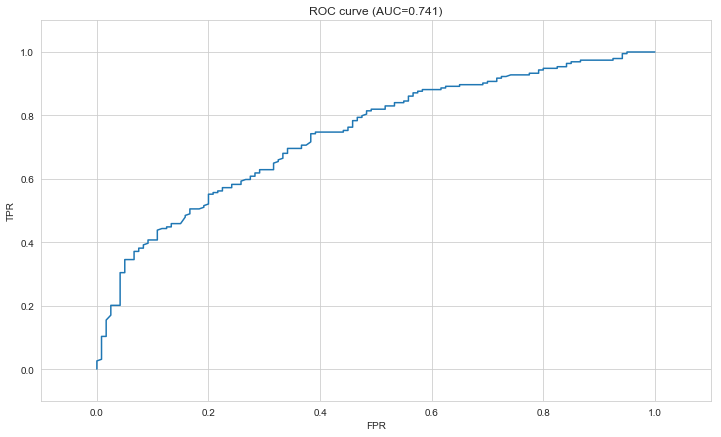

In [19]:
train_predict_model(model, X_train, y_train, X_test, y_test)

In [20]:
feature_score = pd.DataFrame(list(zip(X_train.dtypes.index, model.get_feature_importance(Pool(X_train, label=y_train, cat_features=categorical_features_indices)))),
                columns=['Feature','Score'])

feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')

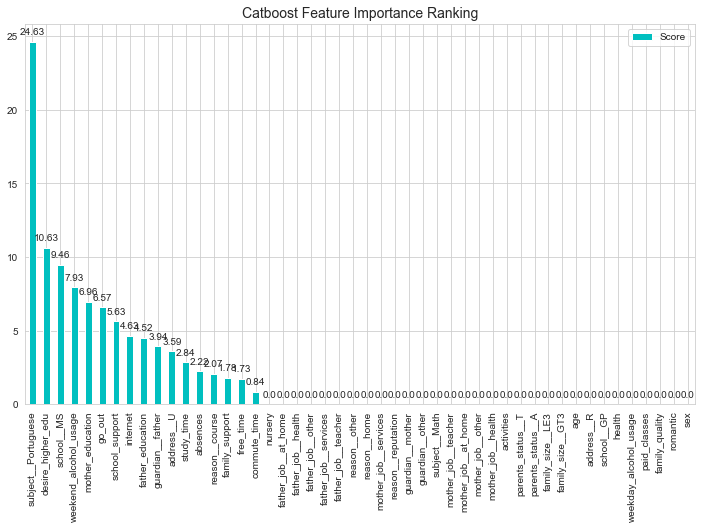

In [21]:
plt.rcParams["figure.figsize"] = (12,7)
ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
ax.set_title("Catboost Feature Importance Ranking", fontsize = 14)
ax.set_xlabel('')

rects = ax.patches

labels = feature_score['Score'].round(2)

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 0.35, label, ha='center', va='bottom')

plt.show()

### Decision Tree

In [51]:
tree = DecisionTreeClassifier(max_depth=9, min_samples_leaf = 3)

In [48]:
from sklearn.model_selection import GridSearchCV, cross_val_score

tree_params = {'max_depth': [3,5,7,9],'min_samples_leaf': [3,5]}
tree_grid = GridSearchCV(DecisionTreeClassifier(), tree_params,cv=5, n_jobs=-1,verbose=True, scoring='accuracy')
tree_grid.fit(X_train, y_train)
print(tree_grid.best_params_)
print(tree_grid.best_score_)


Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


{'max_depth': 9, 'min_samples_leaf': 3}
0.7214912280701754


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    1.8s finished


Accuracy: 0.631
[[ 59  50]
 [ 66 139]]
              precision    recall  f1-score   support

           0       0.47      0.54      0.50       109
           1       0.74      0.68      0.71       205

   micro avg       0.63      0.63      0.63       314
   macro avg       0.60      0.61      0.60       314
weighted avg       0.64      0.63      0.64       314

Auc score: 0.6715148802864175


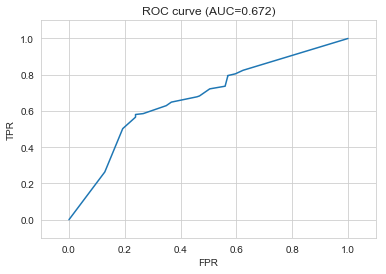

In [52]:
train_predict_model(tree, X_train, y_train, X_test, y_test)

### Random Forest

In [38]:
forest = RandomForestClassifier(n_estimators=500, min_samples_leaf= 3, max_depth=9)

In [33]:
tree_params = {'max_depth': [3,5,7,9],'min_samples_leaf': [3,5], 'n_estimators': [100, 200, 500]}
grid_search = GridSearchCV(RandomForestClassifier(), tree_params, cv=5)
grid_search.fit(X_train, y_train)

print("Наилучшие значения параметров: {}".format(grid_search.best_params_))
print("Наилучшее значение кросс-валидац. правильности:{:.2f}".format(grid_search.best_score_))
accuracy_score(y_test, grid_search.predict(X_test))

Наилучшие значения параметров: {'max_depth': 9, 'min_samples_leaf': 3, 'n_estimators': 500}
Наилучшее значение кросс-валидац. правильности:0.78


0.7292993630573248

Accuracy: 0.761
[[ 69  40]
 [ 35 170]]
              precision    recall  f1-score   support

           0       0.66      0.63      0.65       109
           1       0.81      0.83      0.82       205

   micro avg       0.76      0.76      0.76       314
   macro avg       0.74      0.73      0.73       314
weighted avg       0.76      0.76      0.76       314

Auc score: 0.7935556052808235


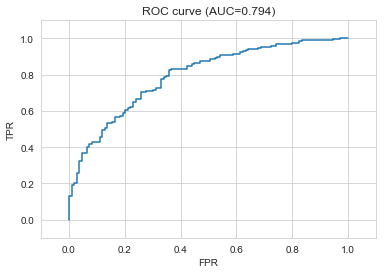

In [53]:
train_predict_model(forest, X_train, y_train, X_test, y_test)